# Bike Sharing Demand
In this notebook, we will be predicting the demand for bike sharing based on the given dataset. You can find the competition and the dataset [here](https://www.kaggle.com/competitions/bike-sharing-demand).

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
import lightgbm as lgb
import xgboost as xgb
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings

### Configurations

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading Data

In [3]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df.shape

(10886, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

## 3. Exploratory Data Analysis

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


In [10]:
# Feature engineering
for dt in [df, test]:
    dt['datetime'] = pd.to_datetime(dt['datetime'])
    dt['hour'] = dt['datetime'].dt.hour
    dt['day'] = dt['datetime'].dt.day
    dt['month'] = dt['datetime'].dt.month
    dt['year'] = dt['datetime'].dt.year
    dt['dayofweek'] = dt['datetime'].dt.dayofweek

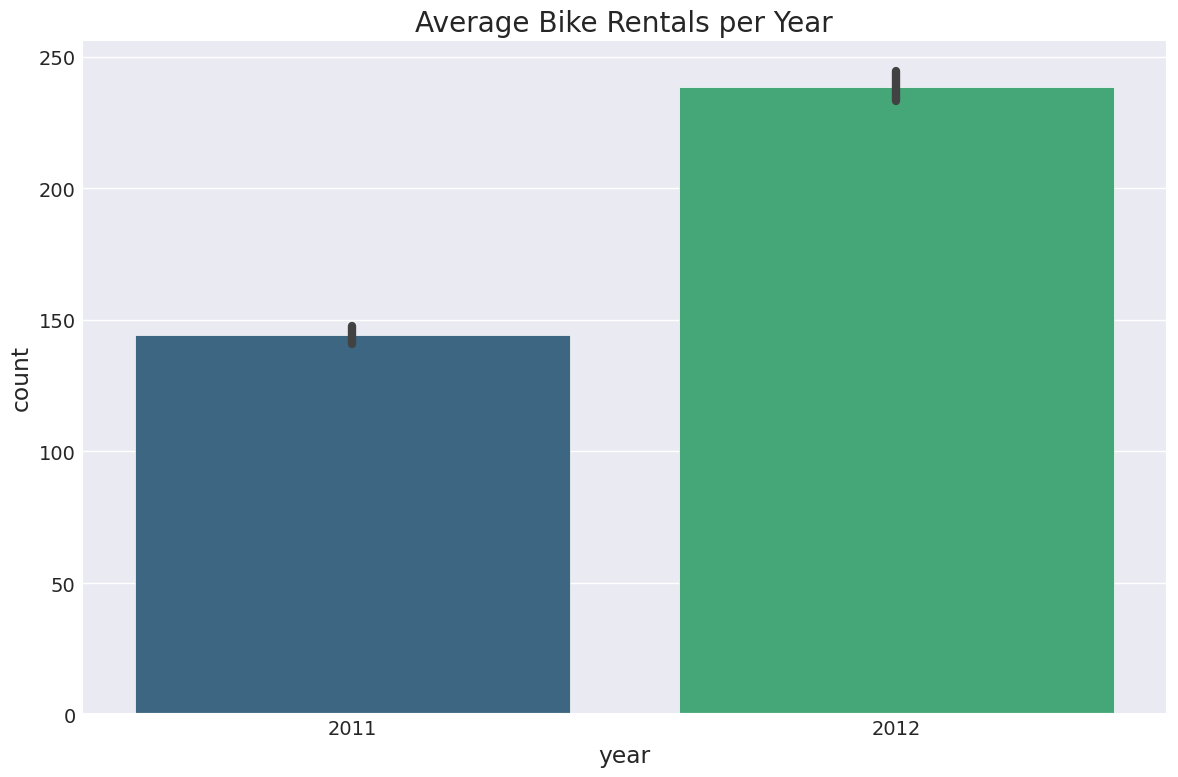

In [11]:
# Count over years
sns.barplot(df, x='year', y='count', palette='viridis')
plt.title("Average Bike Rentals per Year")
plt.tight_layout()

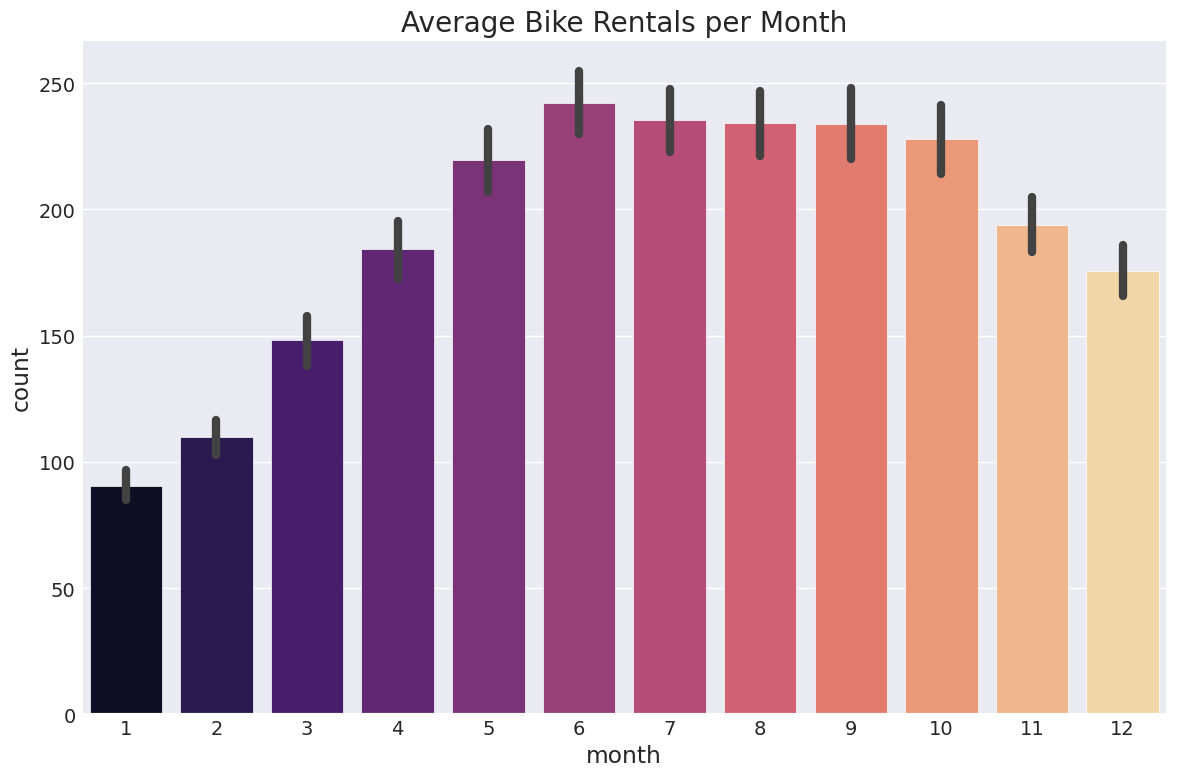

In [12]:
# Monthly trend
sns.barplot(df, x='month', y='count', palette='magma')
plt.title("Average Bike Rentals per Month")
plt.tight_layout()

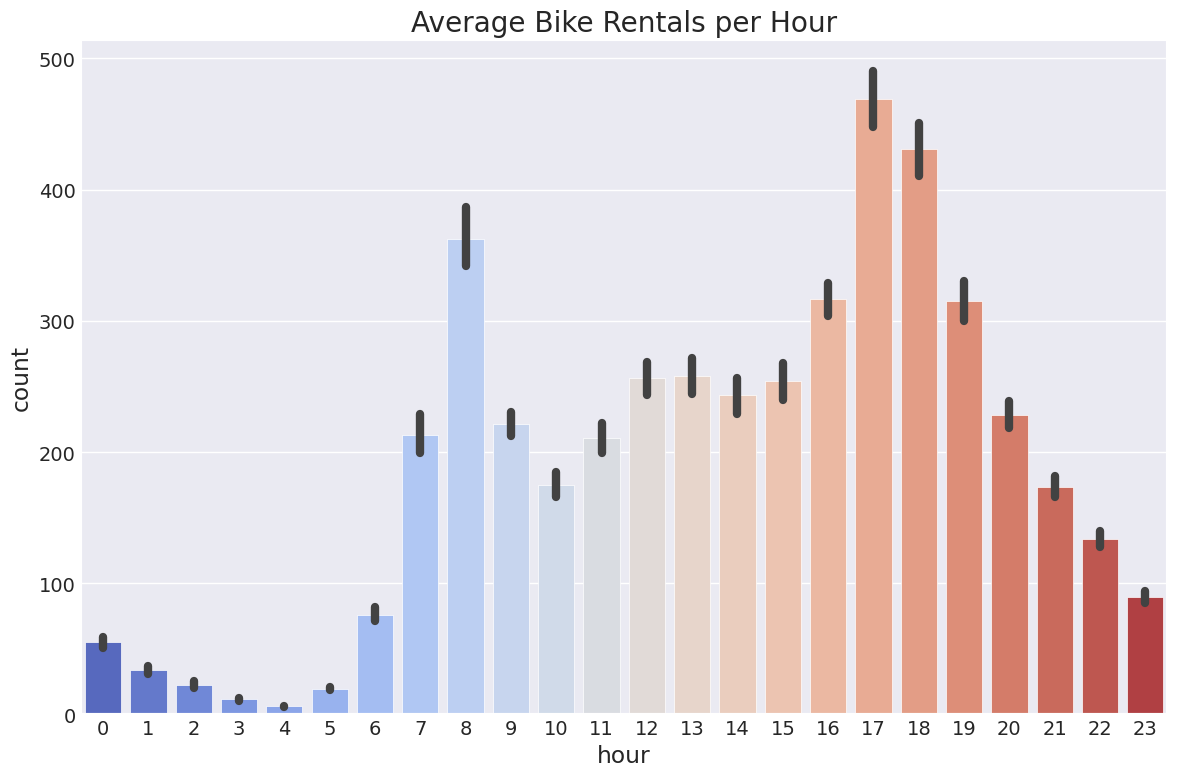

In [13]:
# Hourly pattern
sns.barplot(df, x='hour', y='count', palette='coolwarm')
plt.title("Average Bike Rentals per Hour")
plt.tight_layout()

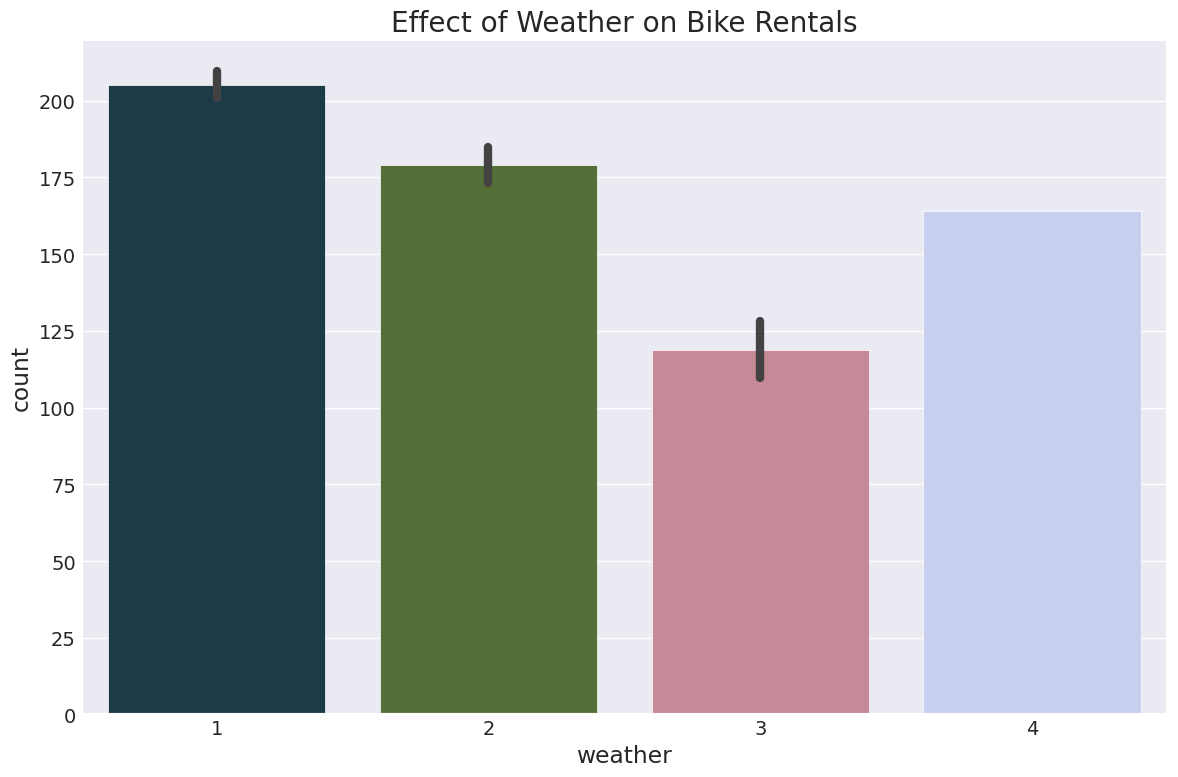

In [14]:
# Effect of weather
sns.barplot(df, x='weather', y='count', palette='cubehelix')
plt.title("Effect of Weather on Bike Rentals")
plt.tight_layout()

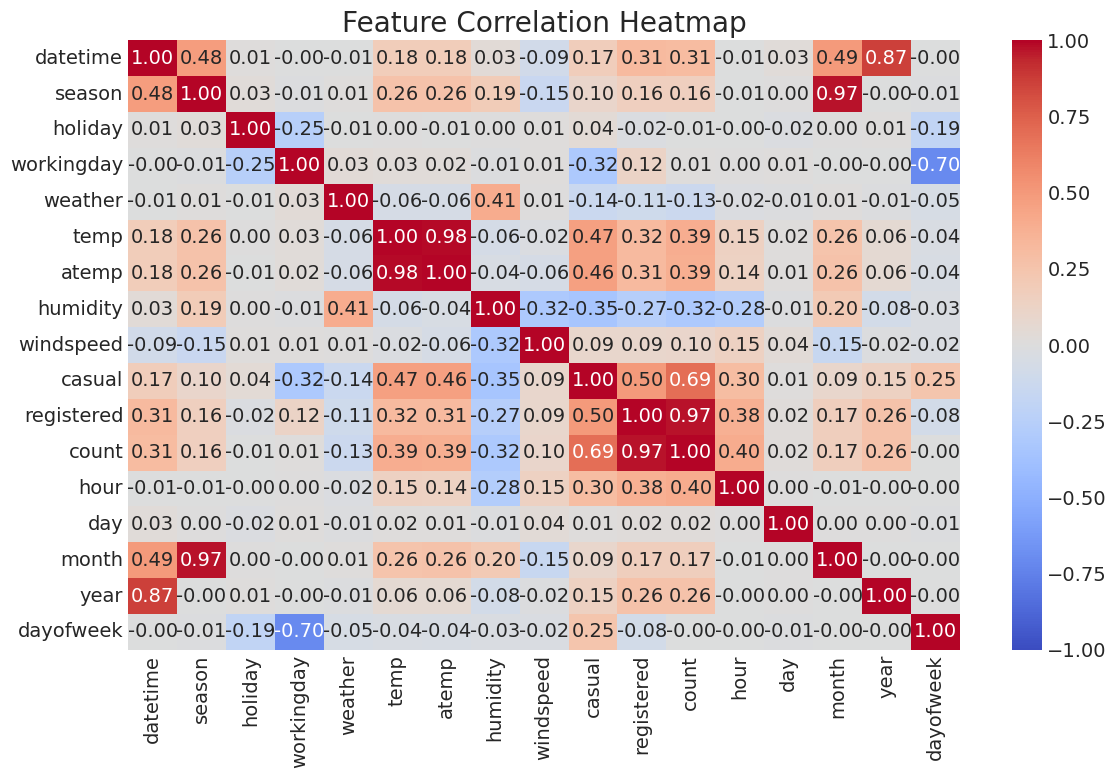

In [15]:
# Correlation heatmap
sns.heatmap(
    df.corr(), 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f",
    vmin=-1,
    vmax=1,
    center=0
)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()

## 4. Data Preprocessing

In [16]:
# Drop the columns that are not needed
x = df.drop(columns=['count', 'datetime', 'casual', 'registered'])
y = df['count']

In [17]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

## 5. Model Training

In [19]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "LightGBM": lgb.LGBMRegressor(verbose=-1),
    "XGBoost": xgb.XGBRegressor()
}

def evaluate(x_train, y_train, x_test, y_test):
    results = []
    for name, model in tqdm(models.items()):
        print(f"Training {name} model...")
        y_pred = model.fit(x_train, y_train).predict(x_test)
        
        results.append({
            "Model": name,
            "R2_Score": r2_score(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred)**0.5
        })
    report = pd.DataFrame(results).sort_values('R2_Score', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

In [20]:
evaluate(x_train, y_train, x_test, y_test)

  0%|          | 0/7 [00:00<?, ?it/s]

Training LinearRegression model...
Training Ridge model...
Training Lasso model...
Training DecisionTreeRegressor model...
Training ExtraTreeRegressor model...
Training LightGBM model...
Training XGBoost model...


,Model,R2_Score,MSE,RMSE
0,LightGBM,0.958613,1366.062295,36.960280
1,XGBoost,0.957754,1394.405640,37.341741
2,DecisionTreeRegressor,0.895709,3442.327824,58.671354
3,ExtraTreeRegressor,0.864776,4463.314509,66.808042
4,Ridge,0.395936,19938.297131,141.203035
5,LinearRegression,0.395871,19940.436220,141.210609
6,Lasso,0.391826,20073.949888,141.682567


### Hyperparameter Tuning

In [21]:
# Hyperparameters for grid search
param_grid = {
    'num_leaves': [31, 100, 500],
    'learning_rate': [0.1],
    'n_estimators': [500, 1000, 2000],
    'max_depth': [7, 10],
}

In [22]:
%%time
grid_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(verbose=-1),
    param_grid=param_grid,
    cv=5,
    scoring='r2'
)
grid_search.fit(x_train, y_train)

CPU times: user 5min 36s, sys: 3.23 s, total: 5min 39s
Wall time: 1min 23s


,estimator,LGBMRegressor(verbose=-1)
,param_grid,"{'learning_rate': [0.1], 'max_depth': [7, 10], 'n_estimators': [500, 1000, ...], 'num_leaves': [31, 100, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [23]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 100}

In [24]:
grid_search.best_score_

np.float64(0.9581368139273556)

## 6. Build Pipeline with the best model, Save the model, Make Submission

In [25]:
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), x.columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(verbose=-1, **grid_search.best_params_))
])
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
# Save the model
joblib.dump(pipeline, 'bike_sharing_demand_pipeline.pkl')

['bike_sharing_demand_pipeline.pkl']

In [27]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({
    'datetime': test['datetime'],
    'count': abs(predictions)
})
submission.head()

,datetime,count
0,2011-01-20 00:00:00,14.315477
1,2011-01-20 01:00:00,0.757071
2,2011-01-20 02:00:00,0.810035
3,2011-01-20 03:00:00,1.019305
4,2011-01-20 04:00:00,0.733242


In [28]:
submission.to_csv('submission.csv', index=False)

## 7. Conclusion
We built a machine learning pipeline to predict the demand for bike sharing. We used the `LightGBM` model as the best model. We saved the pipeline for future use and used it to generate predictions for the test set.